# Fitting

There are two built in fitting engines, `lmfit` and `bumps`.

Import all the packages.

In [2]:
# Import all the packages
from easyCore import np
from easyDiffractionLib.sample import Sample
from easyDiffractionLib import Phases
from easyDiffractionLib.interface import InterfaceFactory
from easyDiffractionLib.Elements.Experiments.Experiment import Pars1D
from easyDiffractionLib.Elements.Experiments.Pattern import Pattern1D

from easyCore.Fitting.Fitting import Fitter

import matplotlib.pyplot as plt

GSAS-II binary directory: /Users/andrewsazonov/Library/Caches/pypoetry/virtualenvs/easydiffractionlib-P2avuC9_-py3.7/lib/python3.7/site-packages/libsDarwin/GSASII/bindist


## Preparing the sample and data

We load up a cif file and then set the experimental parameters.

In [3]:
interface = InterfaceFactory()
c = Phases.from_cif_file('PbSO4.cif')
S = Sample(phases=c, parameters=Pars1D.default(), pattern=Pattern1D.default(), interface=interface)

Temp CIF: /var/folders/vj/bjjkqpsx4js6s242h0t_h45sf5f66_/T/easydiffraction_temp.cif


We can load up some experimental data

In [4]:
file_path = 'PbSO4_xrays_short.xye'
data_x, data_y, data_e = np.loadtxt(file_path, unpack=True)

# Generate the simulation y-data
sim_y_data = interface.fit_func(data_x)

y_calc: [0.000e+00 0.000e+00 0.000e+00 ... 5.094e-27 5.598e-27 4.636e-27]


<IPython.core.display.Javascript object>


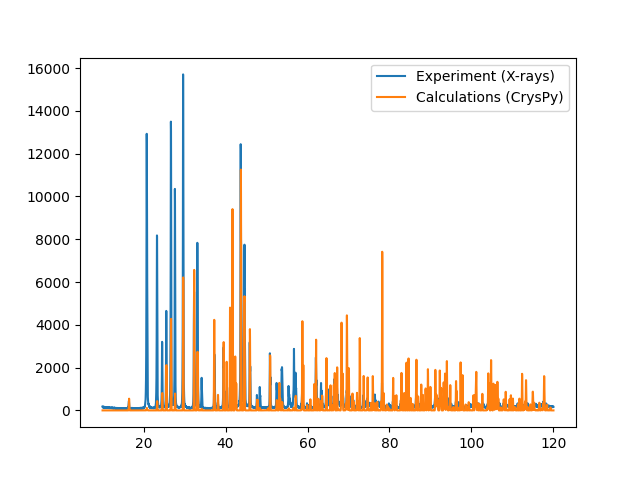

In [5]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

We do not have the correct experimental parameters..

<IPython.core.display.Javascript object>


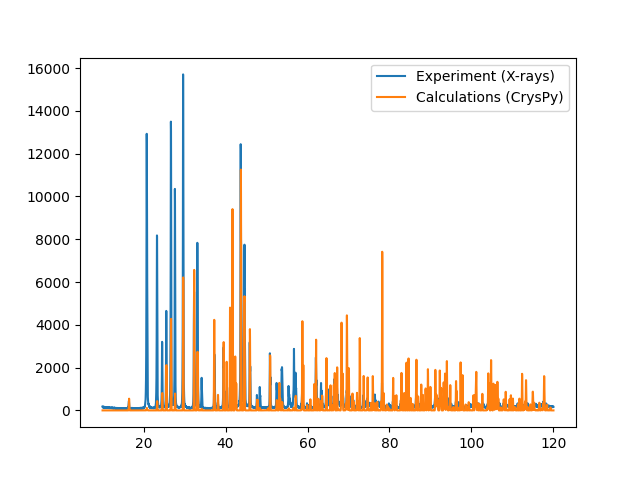

In [6]:
S.parameters.wavelength = 1.54
S.parameters.u_resolution = 0.031
S.parameters.v_resolution = -0.052
S.parameters.w_resolution = 0.032
S.parameters.x_resolution = 0.015
S.parameters.y_resolution = 0.0

#sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Now we need to set the background

In [7]:
from easyDiffractionLib.Elements.Backgrounds.Point import PointBackground, BackgroundPoint

bg = PointBackground(linked_experiment='PbSO4')
bg.append(BackgroundPoint.from_pars(data_x[0], 166))
bg.append(BackgroundPoint.from_pars(16, 36))
bg.append(BackgroundPoint.from_pars(50, 120))
bg.append(BackgroundPoint.from_pars(100, 100))
bg.append(BackgroundPoint.from_pars(data_x[-1], 164))
print(bg)

S.set_background(bg)
print(S.backgrounds)

Background of 5 points.
Collection of 1 backgrounds.


y_calc: [166.    165.458 164.917 ... 163.84  164.777 167.43 ]


<IPython.core.display.Javascript object>


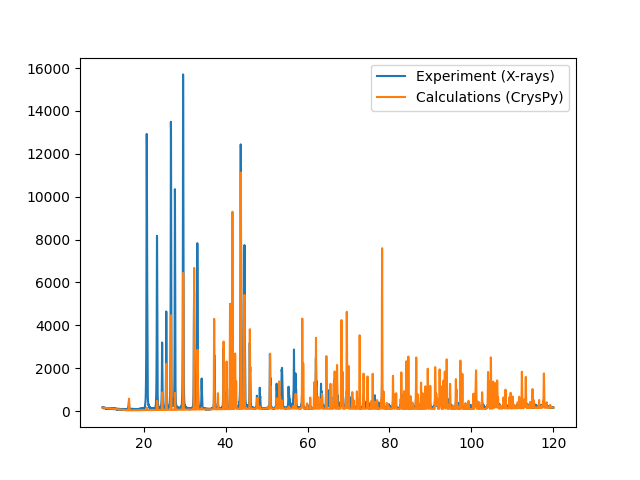

In [8]:
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Select CrysFML calculator

In [9]:
print(interface.available_interfaces)
print(interface.current_interface_name)
interface.switch('CrysFML')
S._updateInterface()
print(interface.current_interface_name)

['CrysPy', 'CrysFML', 'GSAS-II']
CrysPy
CrysFML


y_calc: [166.    165.458 164.917 ... 171.253 171.678 173.028]


<IPython.core.display.Javascript object>


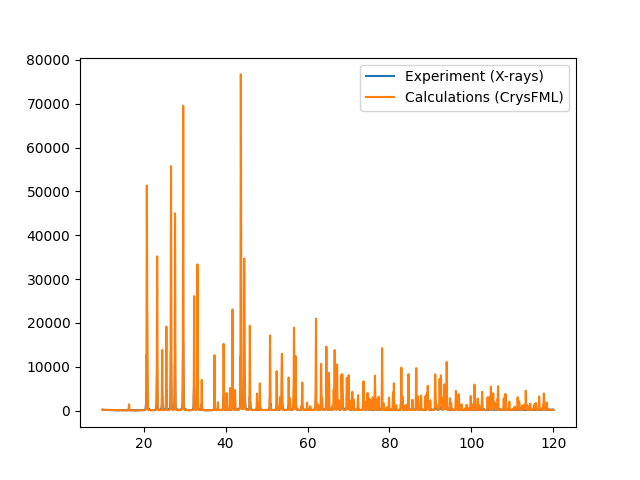

In [10]:
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

Change scale manually

y_calc: [166.    165.458 164.917 ... 164.581 164.696 164.903]


<IPython.core.display.Javascript object>


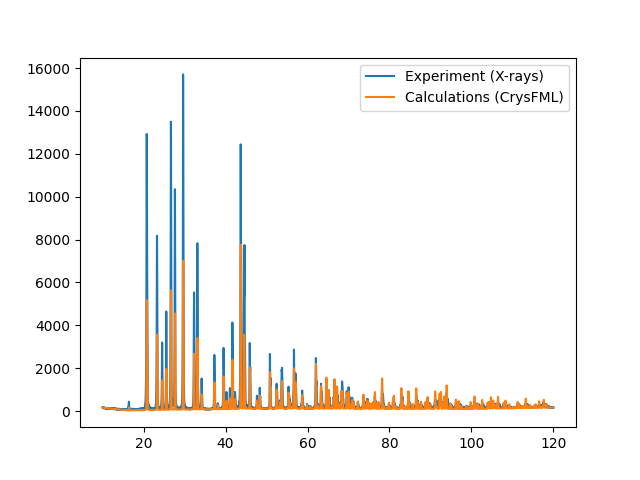

In [13]:
S.pattern.scale = 0.1
sim_y_data = interface.fit_func(data_x)

%matplotlib notebook
plt.plot(data_x, data_y, label='Experiment (X-rays)')
plt.plot(data_x, sim_y_data, label=f'Calculations ({interface.current_interface_name})')
plt.legend()

## Fitting to the data

Initalize the fitting engine and apply a few constraints

In [14]:
f = Fitter(S, interface.fit_func)

# Vary the scale and the BG points
S.pattern.scale.fixed = False
S.pattern.zero_shift.fixed = False
#S.parameters.resolution_u.fixed = False
#S.parameters.resolution_v.fixed = False
#S.parameters.resolution_w.fixed = False
#S.parameters.resolution_x.fixed = False
#S.backgrounds[0][0].y.fixed = False
#S.backgrounds[0][1].y.fixed = False
#S.backgrounds[0][2].y.fixed = False
#S.backgrounds[0][3].y.fixed = False
#S.backgrounds[0][4].y.fixed = False

Select bumps minimizer

In [15]:
print("available minimizers:", f.available_engines)
print()
print("current minimizer:", f.current_engine.name)
print("available methods of current minimizer:", f.available_methods())
print()
print("switch minimizer")
f.switch_engine('bumps')
f_method = 'lm'
print("current minimizer:", f.current_engine.name)
print("available methods of current minimizer:", f.available_methods())

available minimizers: ['lmfit', 'bumps']

current minimizer: lmfit
available methods of current minimizer: ['leastsq', 'least_squares', 'differential_evolution', 'basinhopping', 'ampgo', 'nelder', 'lbfgsb', 'powell', 'cg', 'newton', 'cobyla', 'bfgs']

switch minimizer
current minimizer: bumps
available methods of current minimizer: ['amoeba', 'de', 'dream', 'newton', 'lm', 'mp', 'pt']


Perform the fit

In [16]:
result = f.fit(data_x, data_y, weights=1/data_e, method=f_method)

y_calc: [166.    165.458 164.917 ... 164.581 164.696 164.903]
y_calc: [166.    165.458 164.917 ... 164.692 164.812 165.038]
y_calc: [162.75  162.208 161.667 ... 165.138 165.189 165.301]
y_calc: [1.107e-07 2.767e+01 5.533e+01 ... 1.641e+02 1.642e+02 1.643e+02]
y_calc: [164.375 163.833 163.292 ... 164.914 164.998 165.183]
y_calc: [2.213e-07 5.533e+01 1.107e+02 ... 1.643e+02 1.644e+02 1.646e+02]
y_calc: [165.188 164.646 164.104 ... 164.801 164.895 165.06 ]
y_calc: [165.188 164.646 164.104 ... 164.921 165.023 165.211]
y_calc: [164.781 164.24  163.698 ... 165.091 165.178 165.401]
y_calc: [166.    165.458 164.917 ... 164.804 164.929 165.174]
y_calc: [8.853e-07 1.659e+02 1.653e+02 ... 1.648e+02 1.649e+02 1.652e+02]
y_calc: [165.188 164.646 164.104 ... 165.04  165.15  165.361]
y_calc: [166.    165.458 164.917 ... 164.915 165.045 165.309]
y_calc: [8.853e-07 1.659e+02 1.653e+02 ... 1.649e+02 1.650e+02 1.653e+02]
y_calc: [4.427e-07 1.107e+02 1.657e+02 ... 1.647e+02 1.648e+02 1.651e+02]
y_calc: [1

y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]
y_calc: 

In [17]:
if result.success:
    print("The fit has been successful: {}".format(result.success))
    print("The gooodness of fit is: {}".format(result.goodness_of_fit))
    
sim_y_data = interface.fit_func(data_x)

The fit has been successful: True
The gooodness of fit is: 1507313619948.2712
y_calc: [165.68  165.139 164.597 ... 165.573 165.742 166.077]


<IPython.core.display.Javascript object>


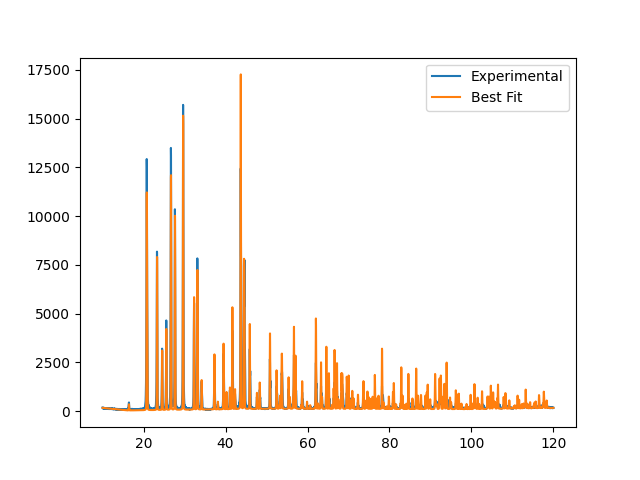

In [18]:
%matplotlib notebook
plt.plot(data_x, data_y, label='Experimental')
plt.plot(data_x, sim_y_data, label='Best Fit')
plt.legend()

In [19]:
print(f'Scale: {S.pattern.scale}')
print(f'Scale: {S.pattern.zero_shift}')

Scale: <Parameter 'scale': 0.2216+/-0.0000, bounds=[-inf:inf]>
Scale: <Parameter 'zero_shift': 0.0148+/-0.0000 deg, bounds=[-inf:inf]>
